In [1]:
from glob import glob
from framed import load_cbmodel
import pandas as pd
from framed.io.sbml import sanitize_id
import cobra
from cobra.io import read_sbml_model
from operator import itemgetter
from multiprocessing import Pool
from tqdm import tqdm
import matplotlib.pyplot as plt
from cobra.flux_analysis import flux_variability_analysis
from matplotlib_venn import venn2
import seaborn as sns
import numpy as np

In [9]:
lbAlldrugs=pd.read_excel('allOtherDrugs_carvemeNcurated_94percent.xlsx', header=0, index_col=0)
pvalueCol=lbAlldrugs.columns[-3]
# lbAlldrugs = lbAlldrugs[(lbAlldrugs['Growth%Change'] == 100.0)]
lbAlldrugs = lbAlldrugs[(lbAlldrugs['CURATEDGrowth%Change'] >= 90)]
print(len(list(lbAlldrugs.prestwickID.values)))
# lbAlldrugs = lbAlldrugs[(lbAlldrugs['Growth%Change'] == 100.0) | (lbAlldrugs['CURATEDGrowth%Change'] >=90)]


21


### loading excel with effect of drugs on proteins

In [2]:
InhibitProteinsDF=pd.read_excel("Btheta_2018AllOtherDrugsInhibit.xlsx", index_col=0)
InhibitProteinsDF['STITCHid']=InhibitProteinsDF['STITCHid'].str.replace("226186.", "")
print('species', list(InhibitProteinsDF.targetSpecies.unique()))
print('number of unique Prestwick IDs', len(list(InhibitProteinsDF.prestwickID.unique())))
print('number of unique STITCH IDs', len(list(InhibitProteinsDF.CIDno.unique())))
InhibitProteinsDF.head()

species ['human', 'not a drug', 'protozoa', 'viruses', 'bacteria', 'antiseptic', 'fungi', 'metazoan parasites', 'veterinary: infections', 'veterinary: metazoan parasites']
number of unique Prestwick IDs 242
number of unique STITCH IDs 232


/tmp/ipykernel_21478/146863096.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  InhibitProteinsDF['STITCHid']=InhibitProteinsDF['STITCHid'].str.replace("226186.", "")


,STITCHid,CarveMeID,ProteinName,symbol,prestwickID,DrugName,ATCcodes,targetSpecies,CIDno,item_id_a,score
1068,BT_2047,WP_008761063_1,thymidylate synthase,NaN,Prestw-738,Folinic acid calcium salt,V03AF03 V03AF04 V03AF06,human,143,CIDm00000143,690
483,BT_0555,WP_008765068_1,amidophosphoribosyltransferase,NaN,Prestw-356,Adenosine 5'-monophosphate monohydrate,-,not a drug,224,CIDm00000224,725
1827,BT_4582,WP_008764741_1,amidophosphoribosyltransferase,NaN,Prestw-356,Adenosine 5'-monophosphate monohydrate,-,not a drug,224,CIDm00000224,725
751,BT_1221,WP_008763420_1,glucose-6-phosphate dehydrogenase,zwf,Prestw-440,Epiandrosterone,A14AA,human,225,CIDm00000225,564
752,BT_1221,WP_008763420_1,glucose-6-phosphate dehydrogenase,zwf,Prestw-697,3-alpha-Hydroxy-5-beta-androstan-17-one,A14AA,human,225,CIDm00000225,564


## Knock-out effect of each drug

In [3]:
DrugsNamesDF=InhibitProteinsDF.copy()
DrugsNamesDF=DrugsNamesDF[['DrugName','prestwickID']]
DrugsNamesDF.drop_duplicates(inplace=True)

# print(DrugsNamesDF)

# UniqueDrugsIdsList=DrugsNamesDF['prestwickID'].unique().tolist()
lbAlldrugs=pd.read_excel('allOtherDrugs_carvemeNcurated_94percent.xlsx', header=0, index_col=0)
pvalueCol=lbAlldrugs.columns[-3]
lbAlldrugs = lbAlldrugs[lbAlldrugs[pvalueCol] <= 0.01]
lbAlldrugs = lbAlldrugs[(lbAlldrugs['Growth%Change'] == 100.0) | (lbAlldrugs['CURATEDGrowth%Change'] >=90)]
UniqueDrugsIdsList=list(lbAlldrugs.prestwickID.unique())

# UniqueDrugsIdsList
# print(UniqueDrugsIdsList)

ProteinsNamesDF=InhibitProteinsDF.copy()
ProteinsNamesDF=ProteinsNamesDF[['STITCHid','CarveMeID', 'ProteinName', 'symbol']]
ProteinsNamesDF.drop_duplicates(inplace=True)
# print(ProteinsNamesDF)

# **DIRECTLY** affected neuroactive REACTIONS

In [4]:
Model=read_sbml_model("LBmedium_Btheta_gram_gapFilled_after.xml.gz")
ObjValue_before=Model.optimize().objective_value
fluxBefore=flux_variability_analysis(Model)
fluxBefore=fluxBefore.round(0)
neuroRxs=pd.read_excel("allNeuroRxsIds.xlsx")
neuroRxsList=list(neuroRxs.ReactionID.unique())
df = pd.DataFrame(columns=['NeuroactiveReaction'])
LB_data=[]
for drugId in tqdm(UniqueDrugsIdsList): #for each drug
    drugData=[]
    drugName=DrugsNamesDF.loc[DrugsNamesDF['prestwickID'] == drugId, 'DrugName']
    genesIdsList=[]
    for x in Model.genes:
        genesIdsList.append(x.id)
#     for modelMetab in Model.metabolites:
#         modelMetabs.append(modelMetab.id)
    SpecificDrugDF = InhibitProteinsDF[InhibitProteinsDF['prestwickID'] == drugId] #for each drug, get the corresponding rows
    UniqueProteinIds = SpecificDrugDF['CarveMeID'].unique().tolist()
    ProteinINmodel=[] #proteins that have STITCH info. and exist in the model
    for proteinId in UniqueProteinIds:
        if proteinId in genesIdsList:
            ProteinINmodel.append(proteinId)
    if ProteinINmodel: #if list is not empty
        with Model as Model:
            directAffectRxs=cobra.manipulation.knock_out_model_genes(Model, ProteinINmodel)
            directAffectNeuro=list(set(directAffectRxs).intersection(set(neuroRxsList))) #from directly affected rxs, are there neuroactive ones?
#             print(drugName.item(),directAffectNeuro)
    #         print('number of directly affected NEUROACTIVE reactions', len(directAffectNeuro))
            Model.optimize()
            fluxAfter=flux_variability_analysis(Model)
            fluxAfter=fluxAfter.round(0)
            fluxesCompare=fluxBefore.compare(fluxAfter) #only keeps rows that at least on the values changed
    #         print('total number of reactions with changed fluxes', len(fluxesCompare))
            directAffectNeuroDF=fluxesCompare[fluxesCompare.index.isin(directAffectNeuro)]
    #         print('number of directly affected NEUROACTIVE reactions', len(directAffectNeuroDF))
            directAffectNeuroRxs=list(directAffectNeuroDF.index.unique())
#             print(drugName.item(),directAffectNeuroRxs)
            totalNeuroRxsDF=fluxesCompare[fluxesCompare.index.isin(neuroRxsList)]
    #         print('number of total affected NEUROACTIVE reactions', len(totalNeuroRxsDF))
            totalNeuroAffectedRxs=list(totalNeuroRxsDF.index.unique())
#             print(totalNeuroAffectedRxs)
            if directAffectNeuroRxs:
                for reaction in directAffectNeuroRxs:
                    row=[reaction, True]
                    drugData.append(row)
                DrugDF=pd.DataFrame(drugData, columns=['NeuroactiveReaction', drugName.item()])
                print(DrugDF)
            else:
                DrugDF=None
    else:
        DrugDF=None
    
    if DrugDF is not None:  
        LB_data.append(DrugDF)

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


100%|██████████| 4/4 [00:20<00:00,  5.17s/it]


In [5]:
modelData=LB_data.copy()

In [6]:
for each_DF in LB_data:
    df=pd.merge(each_DF, df, on='NeuroactiveReaction', how='outer').fillna(False)
df  

,NeuroactiveReaction


In [8]:
noDub=df.copy()
noDub=noDub.drop_duplicates()
# noDub
print('number of directly affected neuroactive reactions', len(noDub))

number of directly affected neuroactive reactions 0


In [10]:
noDub=noDub*1 #from bool values to binary values
noDub=noDub.set_index('NeuroactiveReaction')
# noDub

In [11]:
noDub=noDub.T
noDub["number of models"] = noDub.sum(axis=1) 
noDub= noDub.sort_values(by=['number of models'])
noDub=noDub.drop(columns=['number of models'])
noDub

NeuroactiveReaction


In [12]:
sorteddf=noDub.copy()
sorteddf = sorteddf.reindex(sorted(sorteddf.columns), axis=1)
sorteddf

NeuroactiveReaction


In [ ]:
plt.figure(figsize = (10,5))

s=sns.heatmap(sorteddf, cmap=plt.get_cmap('binary'), xticklabels=True, yticklabels=True, cbar_kws={'label': '0 = metabolite not affected \n 1 = metabolite affected', 'location': 'top'}, linewidths=0.5, square=True)

s.set(xlabel='Neuroactive metabolites', ylabel='Drugs')

# plt.savefig('neuroactiveDrugs_affectedNeuroMetabs_carveme.png', bbox_inches="tight")

# **INDIRECTLY** affected neuroactive REACTIONS

In [23]:
Model=read_sbml_model("LBmedium_Btheta_gram_gapFilled_after.xml.gz")
ObjValue_before=Model.optimize().objective_value
fluxBefore=flux_variability_analysis(Model)
fluxBefore=fluxBefore.round(0)
neuroRxs=pd.read_excel("allNeuroRxsIds.xlsx")
neuroRxsList=list(neuroRxs.ReactionID.unique())
df = pd.DataFrame(columns=['NeuroactiveReaction'])
LB_data=[]
for drugId in tqdm(UniqueDrugsIdsList): #for each drug
    drugData=[]
    drugName=DrugsNamesDF.loc[DrugsNamesDF['prestwickID'] == drugId, 'DrugName']
    genesIdsList=[]
    for x in Model.genes:
        genesIdsList.append(x.id)
#     for modelMetab in Model.metabolites:
#         modelMetabs.append(modelMetab.id)
    SpecificDrugDF = InhibitProteinsDF[InhibitProteinsDF['prestwickID'] == drugId] #for each drug, get the corresponding rows
    UniqueProteinIds = SpecificDrugDF['CarveMeID'].unique().tolist()
    ProteinINmodel=[] #proteins that have STITCH info. and exist in the model
    for proteinId in UniqueProteinIds:
        if proteinId in genesIdsList:
            ProteinINmodel.append(proteinId)
    if ProteinINmodel: #if list is not empty
        with Model as Model:
            directAffectRxs=cobra.manipulation.knock_out_model_genes(Model, ProteinINmodel)
            directAffectNeuro=list(set(directAffectRxs).intersection(set(neuroRxsList))) #from directly affected rxs, are there neuroactive ones?
#             print(drugName.item(),directAffectNeuro)
    #         print('number of directly affected NEUROACTIVE reactions', len(directAffectNeuro))
            Model.optimize()
            fluxAfter=flux_variability_analysis(Model)
            fluxAfter=fluxAfter.round(0)
            fluxesCompare=fluxBefore.compare(fluxAfter) #only keeps rows that at least on the values changed
    #         print('total number of reactions with changed fluxes', len(fluxesCompare))
            directAffectNeuroDF=fluxesCompare[fluxesCompare.index.isin(directAffectNeuro)]
    #         print('number of directly affected NEUROACTIVE reactions', len(directAffectNeuroDF))
            directAffectNeuroRxs=list(directAffectNeuroDF.index.unique())
#             print(drugName.item(),directAffectNeuroRxs)
            totalNeuroRxsDF=fluxesCompare[fluxesCompare.index.isin(neuroRxsList)]
    #         print('number of total affected NEUROACTIVE reactions', len(totalNeuroRxsDF))
            totalNeuroAffectedRxs=list(totalNeuroRxsDF.index.unique())
#             print(totalNeuroAffectedRxs)
            if totalNeuroAffectedRxs:
                for reaction in totalNeuroAffectedRxs:
                    row=[reaction, True]
                    drugData.append(row)
                DrugDF=pd.DataFrame(drugData, columns=['NeuroactiveReaction', drugName.item()])
#                 print(DrugDF)
            else:
                DrugDF=None
    else:
        DrugDF=None
    
    if DrugDF is not None:  
        LB_data.append(DrugDF)

100%|██████████| 4/4 [00:22<00:00,  5.57s/it]


In [24]:
modelData=LB_data.copy()

In [25]:
for each_DF in LB_data:
    df=pd.merge(each_DF, df, on='NeuroactiveReaction', how='outer').fillna(False)
df  

,NeuroactiveReaction,Streptozotocin,Furazolidone
0,ACGS,True,True
1,ACODA,True,True
2,ACODA_1,True,True
3,ACOTA,True,True
4,ACS,True,True
...,...,...,...
77,VALTA,True,True
78,EX_glu__L_e,True,True
79,EX_trp__L_e,True,True
80,Growth,True,True


In [26]:
noDub=df.copy()
noDub=noDub.drop_duplicates()
# noDub
print('number of INdirectly affected neuroactive reactions', len(noDub))

number of INdirectly affected neuroactive reactions 82


In [34]:
noDub=noDub*1 #from bool values to binary values
noDub=noDub.set_index('NeuroactiveReaction')
# noDub

In [35]:
noDub=noDub.T
noDub["number of models"] = noDub.sum(axis=1) 
noDub= noDub.sort_values(by=['number of models'])
noDub=noDub.drop(columns=['number of models'])
noDub

NeuroactiveReaction,3SALATAi,ACGS,ACODA,ACODA_1,ACOTA,ACS,ACS2,ACSERL,ADMDC,AGDC,...,TYRTAi,VALTA,EX_glu__L_e,EX_trp__L_e,Growth,AHSERL4,ASPTA4,CYSTA,LDAPAT,SDPTA
Topiramate,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Disulfiram,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Carbamazepine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Vigabatrin,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,0,0,0,0
Gabapentin,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,0,0,0,0
Acetaminophen,0,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1,1,1


In [36]:
sorteddf=noDub.copy()
sorteddf = sorteddf.reindex(sorted(sorteddf.columns), axis=1)
sorteddf

NeuroactiveReaction,3SALATAi,ACGS,ACODA,ACODA_1,ACOTA,ACS,ACS2,ACSERL,ADMDC,AGDC,...,QMO3,SDPTA,TRPAS2,TRPS1,TRPS2,TRPabc,TYRL,TYRTA,TYRTAi,VALTA
Topiramate,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Disulfiram,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Carbamazepine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Vigabatrin,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,1,1,1
Gabapentin,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,1,1,1
Acetaminophen,0,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1,0,1


[Text(0.5, 425.1132848837209, 'Neuroactive metabolites'),
 Text(159.0, 0.5, 'Drugs')]

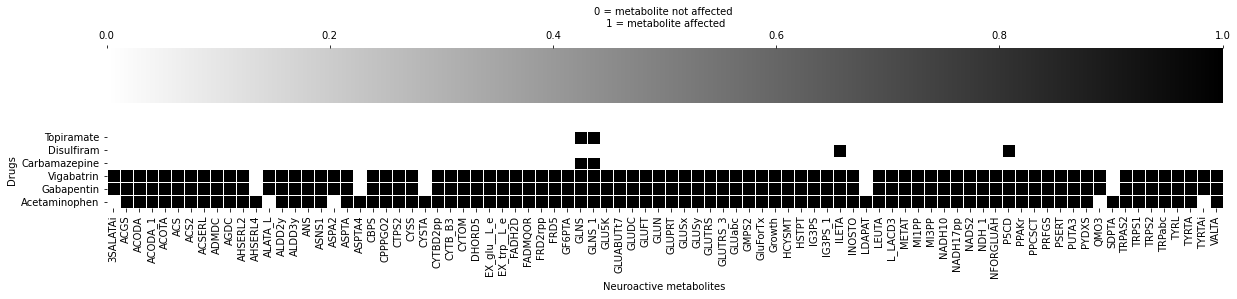

In [40]:
# plt.figure(figsize = (20,10))

# s=sns.heatmap(sorteddf, cmap=plt.get_cmap('binary'), xticklabels=True, yticklabels=True, cbar_kws={'label': '0 = metabolite not affected \n 1 = metabolite affected', 'location': 'top'}, linewidths=0.5, square=True)

# s.set(xlabel='Neuroactive metabolites', ylabel='Drugs')

# # plt.savefig('neuroactiveDrugs_affectedNeuroMetabs_carveme.png', bbox_inches="tight")

## Neuroactive METABOLITES

In [7]:
neuroRxs=pd.read_excel("allNeuroRxsIds.xlsx")
neuroRxsList=list(neuroRxs.ReactionID.unique())
NeuroMetabDF=pd.read_excel('NeuroMetab.xlsx')
NeuroMetabList=NeuroMetabDF['BiGGIDnoM'].tolist()
# modelMetabs=[]
df = pd.DataFrame(columns=['NeuroactiveMetabolite'])
LB_data=[]
for drugId in tqdm(UniqueDrugsIdsList): #for each drug
    drugData=[]
    drugName=DrugsNamesDF.loc[DrugsNamesDF['prestwickID'] == drugId, 'DrugName']
    Model=read_sbml_model("LBmedium_Btheta_gram_gapFilled_after.xml.gz")
    ObjValue_before=Model.optimize().objective_value
    fluxBefore=flux_variability_analysis(Model)
    fluxBefore=fluxBefore.round(0)
    genesIdsList=[]
    for x in Model.genes:
        genesIdsList.append(x.id)
#     for modelMetab in Model.metabolites:
#         modelMetabs.append(modelMetab.id)
    SpecificDrugDF = InhibitProteinsDF[InhibitProteinsDF['prestwickID'] == drugId] #for each drug, get the corresponding rows
    UniqueProteinIds = SpecificDrugDF['CarveMeID'].unique().tolist()
    ProteinINmodel=[] #proteins that have STITCH info. and exist in the model
    for proteinId in UniqueProteinIds:
        if proteinId in genesIdsList:
            ProteinINmodel.append(proteinId)
    if ProteinINmodel: #if list is not empty
        directAffectRxs=cobra.manipulation.knock_out_model_genes(Model, ProteinINmodel)
        directAffectNeuro=list(set(directAffectRxs).intersection(set(neuroRxsList))) #from directly affected rxs, are there neuroactive ones?
#         print('number of directly affected NEUROACTIVE reactions', len(directAffectNeuro))
        Model.optimize()
        fluxAfter=flux_variability_analysis(Model)
        fluxAfter=fluxAfter.round(0)
        fluxesCompare=fluxBefore.compare(fluxAfter) #only keeps rows that at least on the values changed
#         print('total number of reactions with changed fluxes', len(fluxesCompare))
        directAffectNeuroDF=fluxesCompare[fluxesCompare.index.isin(directAffectNeuro)]
#         print('number of directly affected NEUROACTIVE reactions', len(directAffectNeuroDF))
        totalNeuroRxsDF=fluxesCompare[fluxesCompare.index.isin(neuroRxsList)]
#         print('number of total affected NEUROACTIVE reactions', len(totalNeuroRxsDF))
        totalNeuroAffectedRxs=list(totalNeuroRxsDF.index.unique())
        print(totalNeuroAffectedRxs)
        if totalNeuroAffectedRxs:
            for reaction in totalNeuroAffectedRxs:
                metabs=Model.reactions.get_by_id(reaction).metabolites
                metlist=[]
                for met in metabs:
                    metlist.append(met)
                    metlist
                    metlistids=[]
                for m in metlist:
                    metlistids.append(m.id)
                    metlistids
                for Metab in metlistids:
#                     if Metab in modelMetabs:
                    if Metab in NeuroMetabList:
                        row=[Metab, True]
                        drugData.append(row)
            DrugDF=pd.DataFrame(drugData, columns=['NeuroactiveMetabolite', drugName.item()])
            print(DrugDF)
        else:
            DrugDF=None
    else:
        DrugDF=None
    
    if DrugDF is not None:  
        LB_data.append(DrugDF)

 25%|██▌       | 1/4 [00:16<00:49, 16.62s/it]

['ACGS', 'ACODA', 'ACODA_1', 'ACOTA', 'ACS', 'ACS2', 'ACSERL', 'ADMDC', 'AGDC', 'AHSERL2', 'AHSERL4', 'ALDD2y', 'ALDD3y', 'ASNS1', 'ASPTA', 'ASPTA4', 'CBPS', 'CPPPGO2', 'CTPS2', 'CYSS', 'CYSTA', 'CYTBD2pp', 'CYTB_B3', 'CYTOM', 'DHORD5', 'FADH2D', 'FADMQOR', 'FRD2rpp', 'FRD5', 'GF6PTA', 'GLNS', 'GLNS_1', 'GLU5K', 'GLUABUTt7', 'GLUDC', 'GLUFT', 'GLUN', 'GLUPRT', 'GLUSx', 'GLUSy', 'GLUTRS', 'GLUTRS_3', 'GLUabc', 'GMPS2', 'GluForTx', 'HCYSMT', 'HSTPT', 'IG3PS', 'IG3PS_1', 'ILETA', 'INOSTO', 'LDAPAT', 'LEUTA', 'L_LACD3', 'METAT', 'MI1PP', 'MI3PP', 'NADH10', 'NADH17pp', 'NADS2', 'NDH_1', 'NFORGLUAH', 'P5CD', 'PPAKr', 'PPCSCT', 'PRFGS', 'PSERT', 'PUTA3', 'PYDXS', 'QMO3', 'SDPTA', 'TRPAS2', 'TRPS2', 'TRPabc', 'TYRL', 'VALTA', 'EX_glu__L_e', 'EX_trp__L_e', 'Growth']
   NeuroactiveMetabolite  Furazolidone
0               glu__L_c          True
1                   ac_c          True
2                   ac_c          True
3               glu__L_c          True
4                   ac_c          Tru

 50%|█████     | 2/4 [00:29<00:28, 14.13s/it]

[]


 75%|███████▌  | 3/4 [00:41<00:13, 13.55s/it]

[]


100%|██████████| 4/4 [00:58<00:00, 14.50s/it]

['ACGS', 'ACODA', 'ACODA_1', 'ACOTA', 'ACS', 'ACS2', 'ACSERL', 'ADMDC', 'AGDC', 'AHSERL2', 'AHSERL4', 'ALDD2y', 'ALDD3y', 'ANS', 'ASNS1', 'ASPTA', 'ASPTA4', 'CBPS', 'CPPPGO2', 'CTPS2', 'CYSS', 'CYSTA', 'CYTBD2pp', 'CYTB_B3', 'CYTOM', 'DHORD5', 'FADH2D', 'FADMQOR', 'FRD2rpp', 'FRD5', 'GF6PTA', 'GLNS', 'GLNS_1', 'GLU5K', 'GLUABUTt7', 'GLUDC', 'GLUFT', 'GLUN', 'GLUPRT', 'GLUSx', 'GLUSy', 'GLUTRS', 'GLUTRS_3', 'GLUabc', 'GMPS2', 'GluForTx', 'HCYSMT', 'HSTPT', 'IG3PS', 'IG3PS_1', 'ILETA', 'INOSTO', 'LDAPAT', 'LEUTA', 'L_LACD3', 'METAT', 'MI1PP', 'MI3PP', 'NADH10', 'NADH17pp', 'NADS2', 'NDH_1', 'NFORGLUAH', 'P5CD', 'PPAKr', 'PPCSCT', 'PRFGS', 'PSERT', 'PUTA3', 'PYDXS', 'SDPTA', 'TRPAS2', 'TRPS1', 'TRPS2', 'TRPabc', 'TYRL', 'TYRTA', 'VALTA', 'EX_glu__L_e', 'EX_trp__L_e', 'Growth']
   NeuroactiveMetabolite  Streptozotocin
0               glu__L_c            True
1                   ac_c            True
2                   ac_c            True
3               glu__L_c            True
4         

In [8]:
modelData=LB_data.copy()

In [9]:
for each_DF in LB_data:
    df=pd.merge(each_DF, df, on='NeuroactiveMetabolite', how='outer').fillna(False)
# df  

In [10]:
noDub=df.copy()
noDub=noDub.drop_duplicates()
# noDub

In [11]:
noDub=noDub*1 #from bool values to binary values
noDub=noDub.set_index('NeuroactiveMetabolite')
# noDub

In [12]:
noDub=noDub.T
noDub["number of models"] = noDub.sum(axis=1) 
noDub= noDub.sort_values(by=['number of models'])
noDub=noDub.drop(columns=['number of models'])
noDub

NeuroactiveMetabolite,glu__L_c,ac_c,ppa_c,amet_c,mqn8_c,mqn7_c,mqn6_c,glu__L_e,inost_c,trp__L_c,trp__L_e
Streptozotocin,1,1,1,1,1,1,1,1,1,1,1
Furazolidone,1,1,1,1,1,1,1,1,1,1,1


In [15]:
sorteddf=noDub.copy()
sorteddf = sorteddf.reindex(sorted(sorteddf.columns), axis=1)
sorteddf

NeuroactiveMetabolite,ac_c,amet_c,glu__L_c,glu__L_e,inost_c,mqn6_c,mqn7_c,mqn8_c,ppa_c,trp__L_c,trp__L_e
Streptozotocin,1,1,1,1,1,1,1,1,1,1,1
Furazolidone,1,1,1,1,1,1,1,1,1,1,1


[Text(0.5, -23.000000000000007, 'Neuroactive metabolites'),
 Text(13.99999999999999, 0.5, 'Drugs')]

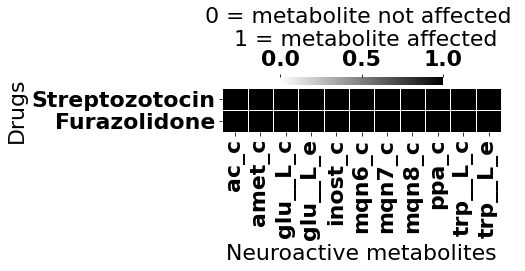

In [21]:
plt.figure(figsize = (5,1))
font = {'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

s=sns.heatmap(sorteddf,vmin=0, vmax=1, cmap=plt.get_cmap('binary'), xticklabels=True, yticklabels=True, cbar_kws={'label': '0 = metabolite not affected \n 1 = metabolite affected', 'location': 'top'}, linewidths=0.5)

s.set(xlabel='Neuroactive metabolites', ylabel='Drugs')

# plt.savefig('neuroactiveDrugs_affectedNeuroMetabs_carveme.png', bbox_inches="tight")

# CURATED

## **DIRECTLY** affected neuroactive REACTIONS

In [4]:
M9Series=pd.read_excel('BthetaCuratedMinimalMedium.xlsx', index_col=0)
M9List=M9Series.index.tolist()
Media=pd.read_excel('carvemeMedia.xlsx')
M9CarvemeMedium=Media['M9'].tolist()
CarvemeM9Metabs=list(set(M9CarvemeMedium) - set(M9List))
M9Medium=M9List+CarvemeM9Metabs
LBmediumList=Media['LB'].tolist()
LBmedium=LBmediumList+M9Medium
MediumList=[LBmedium]
for medium in MediumList:
    Model=read_sbml_model('Btheta_curated.xml')  
    Model.optimize()
    ModelMedium=[v for v in Model.medium.keys()] # has all Exchange reactions active
    ModelMedium.remove("EX_glc(e)")
    Model.reactions.get_by_id('EX_o2(e)').bounds = (0.0, 1000.0)        
    for mediumRx in ModelMedium: #go through each reaction in medium
        if mediumRx not in medium: #put the rxs that are not in M9 composition as inactive so that we have M9 medium
            Model.reactions.get_by_id(mediumRx).bounds = (0.0, 1000.0) #put the flux as INACTIVE
    for Ex_rx in Model.medium.keys():
        Model.reactions.get_by_id(Ex_rx).lower_bound = -10
        Model.reactions.get_by_id(Ex_rx).upper_bound = 1000
    Model.optimize()
    fluxBefore=flux_variability_analysis(Model)
    fluxBefore=fluxBefore.round(0)
    neuroRxs=pd.read_excel("curated_neuroRxs.xlsx")
    neuroRxsList=list(neuroRxs.ReactionID.unique())
    df = pd.DataFrame(columns=['NeuroactiveReaction'])
    LB_data=[]
    for drugId in tqdm(UniqueDrugsIdsList): #for each drug
        drugData=[]
        drugName=DrugsNamesDF.loc[DrugsNamesDF['prestwickID'] == drugId, 'DrugName']
        genesIdsList=[]
        for x in Model.genes:
            genesIdsList.append(x.id)
    #     for modelMetab in Model.metabolites:
    #         modelMetabs.append(modelMetab.id)
        SpecificDrugDF = InhibitProteinsDF[InhibitProteinsDF['prestwickID'] == drugId] #for each drug, get the corresponding rows
        UniqueProteinIds = SpecificDrugDF['STITCHid'].unique().tolist()
        ProteinINmodel=[] #proteins that have STITCH info. and exist in the model
        for proteinId in UniqueProteinIds:
            if proteinId in genesIdsList:
                ProteinINmodel.append(proteinId)
        if ProteinINmodel: #if list is not empty
            with Model as Model:
                directAffectRxs=cobra.manipulation.knock_out_model_genes(Model, ProteinINmodel)
                directAffectNeuro=list(set(directAffectRxs).intersection(set(neuroRxsList))) #from directly affected rxs, are there neuroactive ones?
    #             print(drugName.item(),directAffectNeuro)
        #         print('number of directly affected NEUROACTIVE reactions', len(directAffectNeuro))
                Model.optimize()
                fluxAfter=flux_variability_analysis(Model)
                fluxAfter=fluxAfter.round(0)
                fluxesCompare=fluxBefore.compare(fluxAfter) #only keeps rows that at least on the values changed
        #         print('total number of reactions with changed fluxes', len(fluxesCompare))
                directAffectNeuroDF=fluxesCompare[fluxesCompare.index.isin(directAffectNeuro)]
        #         print('number of directly affected NEUROACTIVE reactions', len(directAffectNeuroDF))
                directAffectNeuroRxs=list(directAffectNeuroDF.index.unique())
    #             print(drugName.item(),directAffectNeuroRxs)
                totalNeuroRxsDF=fluxesCompare[fluxesCompare.index.isin(neuroRxsList)]
        #         print('number of total affected NEUROACTIVE reactions', len(totalNeuroRxsDF))
                totalNeuroAffectedRxs=list(totalNeuroRxsDF.index.unique())
    #             print(totalNeuroAffectedRxs)
                if directAffectNeuroRxs:
                    for reaction in directAffectNeuroRxs:
                        row=[reaction, True]
                        drugData.append(row)
                    DrugDF=pd.DataFrame(drugData, columns=['NeuroactiveReaction', drugName.item()])
                    print(DrugDF)
                else:
                    DrugDF=None
        else:
            DrugDF=None

        if DrugDF is not None:  
            LB_data.append(DrugDF)

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


100%|██████████| 4/4 [00:15<00:00,  3.85s/it]


In [5]:
modelData=LB_data.copy()

In [6]:
for each_DF in modelData:
    df=pd.merge(each_DF, df, on='NeuroactiveReaction', how='outer').fillna(False)
df  

,NeuroactiveReaction


In [29]:
noDub=df.copy()
noDub=noDub.drop_duplicates()
# noDub
print('number of directly affected neuroactive reactions', len(noDub))

number of directly affected neuroactive reactions 82


In [12]:
noDub=noDub*1 #from bool values to binary values
noDub=noDub.set_index('NeuroactiveReaction')
# noDub

In [13]:
noDub=noDub.T
noDub["number of models"] = noDub.sum(axis=1) 
noDub= noDub.sort_values(by=['number of models'])
noDub=noDub.drop(columns=['number of models'])
noDub

NeuroactiveReaction


In [14]:
sorteddf=noDub.copy()
sorteddf = sorteddf.reindex(sorted(sorteddf.columns), axis=1)
sorteddf

NeuroactiveReaction


In [ ]:
plt.figure(figsize = (10,5))

s=sns.heatmap(sorteddf, cmap=plt.get_cmap('binary'), xticklabels=True, yticklabels=True, cbar_kws={'label': '0 = metabolite not affected \n 1 = metabolite affected', 'location': 'top'}, linewidths=0.5, square=True)

s.set(xlabel='Neuroactive metabolites', ylabel='Drugs')

# plt.savefig('neuroactiveDrugs_affectedNeuroMetabs_carveme.png', bbox_inches="tight")

# **INDIRECTLY** affected neuroactive REACTIONS

In [7]:
M9Series=pd.read_excel('BthetaCuratedMinimalMedium.xlsx', index_col=0)
M9List=M9Series.index.tolist()
Media=pd.read_excel('carvemeMedia.xlsx')
M9CarvemeMedium=Media['M9'].tolist()
CarvemeM9Metabs=list(set(M9CarvemeMedium) - set(M9List))
M9Medium=M9List+CarvemeM9Metabs
LBmediumList=Media['LB'].tolist()
LBmedium=LBmediumList+M9Medium
MediumList=[LBmedium]
for medium in MediumList:
    Model=read_sbml_model('Btheta_curated.xml')  
    Model.optimize()
    ModelMedium=[v for v in Model.medium.keys()] # has all Exchange reactions active
    ModelMedium.remove("EX_glc(e)")
    Model.reactions.get_by_id('EX_o2(e)').bounds = (0.0, 1000.0)        
    for mediumRx in ModelMedium: #go through each reaction in medium
        if mediumRx not in medium: #put the rxs that are not in M9 composition as inactive so that we have M9 medium
            Model.reactions.get_by_id(mediumRx).bounds = (0.0, 1000.0) #put the flux as INACTIVE
    for Ex_rx in Model.medium.keys():
        Model.reactions.get_by_id(Ex_rx).lower_bound = -10
        Model.reactions.get_by_id(Ex_rx).upper_bound = 1000
    Model.optimize()
    fluxBefore=flux_variability_analysis(Model)
    fluxBefore=fluxBefore.round(0)
    neuroRxs=pd.read_excel("curated_neuroRxs.xlsx")
    neuroRxsList=list(neuroRxs.ReactionID.unique())
    df = pd.DataFrame(columns=['NeuroactiveReaction'])
    LB_data=[]
    for drugId in tqdm(UniqueDrugsIdsList): #for each drug
        drugData=[]
        drugName=DrugsNamesDF.loc[DrugsNamesDF['prestwickID'] == drugId, 'DrugName']
        genesIdsList=[]
        for x in Model.genes:
            genesIdsList.append(x.id)
    #     for modelMetab in Model.metabolites:
    #         modelMetabs.append(modelMetab.id)
        SpecificDrugDF = InhibitProteinsDF[InhibitProteinsDF['prestwickID'] == drugId] #for each drug, get the corresponding rows
        UniqueProteinIds = SpecificDrugDF['STITCHid'].unique().tolist()
        ProteinINmodel=[] #proteins that have STITCH info. and exist in the model
        for proteinId in UniqueProteinIds:
            if proteinId in genesIdsList:
                ProteinINmodel.append(proteinId)
        if ProteinINmodel: #if list is not empty
            with Model as Model:
                directAffectRxs=cobra.manipulation.knock_out_model_genes(Model, ProteinINmodel)
                directAffectNeuro=list(set(directAffectRxs).intersection(set(neuroRxsList))) #from directly affected rxs, are there neuroactive ones?
    #             print(drugName.item(),directAffectNeuro)
        #         print('number of directly affected NEUROACTIVE reactions', len(directAffectNeuro))
                Model.optimize()
                fluxAfter=flux_variability_analysis(Model)
                fluxAfter=fluxAfter.round(0)
                fluxesCompare=fluxBefore.compare(fluxAfter) #only keeps rows that at least on the values changed
        #         print('total number of reactions with changed fluxes', len(fluxesCompare))
                directAffectNeuroDF=fluxesCompare[fluxesCompare.index.isin(directAffectNeuro)]
        #         print('number of directly affected NEUROACTIVE reactions', len(directAffectNeuroDF))
                directAffectNeuroRxs=list(directAffectNeuroDF.index.unique())
    #             print(drugName.item(),directAffectNeuroRxs)
                totalNeuroRxsDF=fluxesCompare[fluxesCompare.index.isin(neuroRxsList)]
        #         print('number of total affected NEUROACTIVE reactions', len(totalNeuroRxsDF))
                totalNeuroAffectedRxs=list(totalNeuroRxsDF.index.unique())
    #             print(totalNeuroAffectedRxs)
                if totalNeuroAffectedRxs:
                    for reaction in totalNeuroAffectedRxs:
                        row=[reaction, True]
                        drugData.append(row)
                    DrugDF=pd.DataFrame(drugData, columns=['NeuroactiveReaction', drugName.item()])
    #                 print(DrugDF)
                else:
                    DrugDF=None
        else:
            DrugDF=None

        if DrugDF is not None:  
            LB_data.append(DrugDF)

100%|██████████| 4/4 [00:16<00:00,  4.14s/it]


In [10]:
modelData=LB_data.copy()

In [11]:
for each_DF in modelData:
    df=pd.merge(each_DF, df, on='NeuroactiveReaction', how='outer').fillna(False)
df  

,NeuroactiveReaction,Streptozotocin,Triclosan,Ofloxacin,Furazolidone
0,26DAPLLATi,True,True,True,True
1,ACGS,True,True,True,True
2,ACKr,True,True,True,True
3,ACODA,True,True,True,True
4,ACOTA,True,True,True,True
...,...,...,...,...,...
79,TYRTA,True,True,True,True
80,UAMAGS,True,True,True,True
81,VALTA,True,True,True,True
82,UHGADA_HP,False,False,True,False


In [13]:
noDub=df.copy()
noDub=noDub.drop_duplicates()
# noDub
print('number of INdirectly affected neuroactive reactions', len(noDub))

number of INdirectly affected neuroactive reactions 84


In [14]:
directRxs=set(list(df.NeuroactiveReaction.unique()))


In [15]:
noDub=noDub*1 #from bool values to binary values
noDub=noDub.set_index('NeuroactiveReaction')
# noDub

In [16]:
noDub=noDub.T
noDub["number of models"] = noDub.sum(axis=1) 
noDub= noDub.sort_values(by=['number of models'])
noDub=noDub.drop(columns=['number of models'])
noDub

NeuroactiveReaction,26DAPLLATi,ACGS,ACKr,ACODA,ACOTA,ACtr,AGDC,AHSERL2,AHSERL3,AMAOTr,...,TRPAS2,TRPS1,TRPS2,TRPTA,TRPt2r,TYRTA,UAMAGS,VALTA,UHGADA_HP,GLUDxi
Streptozotocin,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
Triclosan,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
Ofloxacin,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
Furazolidone,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,1


In [17]:
sorteddf=noDub.copy()
sorteddf = sorteddf.reindex(sorted(sorteddf.columns), axis=1)
sorteddf

NeuroactiveReaction,26DAPLLATi,ACGS,ACKr,ACODA,ACOTA,ACtr,AGDC,AHSERL2,AHSERL3,AMAOTr,...,SKATOLEF,TRPAS2,TRPS1,TRPS2,TRPTA,TRPt2r,TYRTA,UAMAGS,UHGADA_HP,VALTA
Streptozotocin,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,1
Triclosan,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,1
Ofloxacin,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Furazolidone,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,1


[Text(0.5, 395.407484939759, 'Neuroactive metabolites'),
 Text(159.0, 0.5, 'Drugs')]

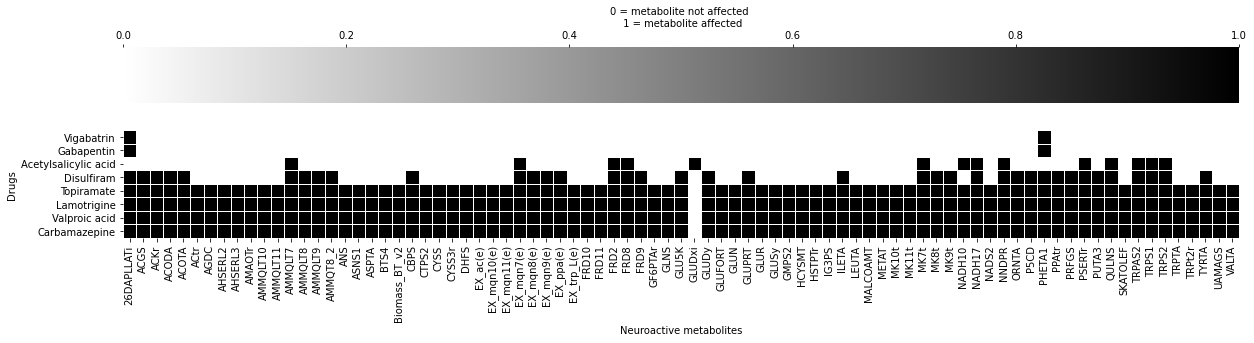

In [23]:
plt.figure(figsize = (20,10))

s=sns.heatmap(sorteddf, cmap=plt.get_cmap('binary'), xticklabels=True, yticklabels=True, cbar_kws={'label': '0 = metabolite not affected \n 1 = metabolite affected', 'location': 'top'}, linewidths=0.5, square=True)

s.set(xlabel='Neuroactive metabolites', ylabel='Drugs')

# plt.savefig('neuroactiveDrugs_affectedNeuroMetabs_carveme.png', bbox_inches="tight")

## Neuroactive METABOLITES

In [18]:
neuroRxs=pd.read_excel("curated_neuroRxs.xlsx")
neuroRxsList=list(neuroRxs.ReactionID.unique())
NeuroMetabDF=pd.read_excel('curated_neuroMetabs.xlsx')
NeuroMetabList=NeuroMetabDF['BiGGIDnoM'].tolist()
# modelMetabs=[]
df = pd.DataFrame(columns=['NeuroactiveMetabolite'])
M9Series=pd.read_excel('BthetaCuratedMinimalMedium.xlsx', index_col=0)
M9List=M9Series.index.tolist()
Media=pd.read_excel('carvemeMedia.xlsx')
M9CarvemeMedium=Media['M9'].tolist()
CarvemeM9Metabs=list(set(M9CarvemeMedium) - set(M9List))
M9Medium=M9List+CarvemeM9Metabs
LBmediumList=Media['LB'].tolist()
LBmedium=LBmediumList+M9Medium
MediumList=[LBmedium]
for medium in MediumList:
    Model=read_sbml_model('Btheta_curated.xml')  
    Model.optimize()
    ModelMedium=[v for v in Model.medium.keys()] # has all Exchange reactions active
    ModelMedium.remove("EX_glc(e)")
    Model.reactions.get_by_id('EX_o2(e)').bounds = (0.0, 1000.0)        
    for mediumRx in ModelMedium: #go through each reaction in medium
        if mediumRx not in medium: #put the rxs that are not in M9 composition as inactive so that we have M9 medium
            Model.reactions.get_by_id(mediumRx).bounds = (0.0, 1000.0) #put the flux as INACTIVE
    for Ex_rx in Model.medium.keys():
        Model.reactions.get_by_id(Ex_rx).lower_bound = -10
        Model.reactions.get_by_id(Ex_rx).upper_bound = 1000
    Model.optimize()
    fluxBefore=flux_variability_analysis(Model)
    fluxBefore=fluxBefore.round(0)
    LB_data=[]
    for drugId in tqdm(UniqueDrugsIdsList): #for each drug
        drugData=[]
        drugName=DrugsNamesDF.loc[DrugsNamesDF['prestwickID'] == drugId, 'DrugName']
        genesIdsList=[]
        for x in Model.genes:
            genesIdsList.append(x.id)
    #     for modelMetab in Model.metabolites:
    #         modelMetabs.append(modelMetab.id)
        SpecificDrugDF = InhibitProteinsDF[InhibitProteinsDF['prestwickID'] == drugId] #for each drug, get the corresponding rows
        UniqueProteinIds = SpecificDrugDF['STITCHid'].unique().tolist()
        ProteinINmodel=[] #proteins that have STITCH info. and exist in the model
        for proteinId in UniqueProteinIds:
            if proteinId in genesIdsList:
                ProteinINmodel.append(proteinId)
        if ProteinINmodel: #if list is not empty
            with Model as Model:
                directAffectRxs=cobra.manipulation.knock_out_model_genes(Model, ProteinINmodel)
                directAffectNeuro=list(set(directAffectRxs).intersection(set(neuroRxsList))) #from directly affected rxs, are there neuroactive ones?
        #         print('number of directly affected NEUROACTIVE reactions', len(directAffectNeuro))
                Model.optimize()
                fluxAfter=flux_variability_analysis(Model)
                fluxAfter=fluxAfter.round(0)
                fluxesCompare=fluxBefore.compare(fluxAfter) #only keeps rows that at least on the values changed
                directAffectNeuroDF=fluxesCompare[fluxesCompare.index.isin(directAffectNeuro)]
                totalNeuroRxsDF=fluxesCompare[fluxesCompare.index.isin(neuroRxsList)]
                totalNeuroAffectedRxs=list(totalNeuroRxsDF.index.unique())
                if totalNeuroAffectedRxs:
                    for reaction in totalNeuroAffectedRxs:
                        metabs=Model.reactions.get_by_id(reaction).metabolites
                        metlist=[]
                        for met in metabs:
                            metlist.append(met)
                            metlist
                            metlistids=[]
                        for m in metlist:
                            metlistids.append(m.id)
#                         metlistids = [re.sub('\[', '_', metabolito) for metabolito in metlistids]
#                         metlistids = [re.sub('\]', '', metabolito) for metabolito in metlistids]
                        for Metab in metlistids:
                            if Metab in NeuroMetabList:
                                row=[Metab, True]
                                drugData.append(row)
                                
                    DrugDF=pd.DataFrame(drugData, columns=['NeuroactiveMetabolite', drugName.item()])
                else:
                    DrugDF=pd.DataFrame()
        else:
            DrugDF=pd.DataFrame()

        if not DrugDF.empty:   
            LB_data.append(DrugDF)

100%|██████████| 4/4 [00:15<00:00,  4.00s/it]


In [19]:
modelData=LB_data.copy()
modelData

[   NeuroactiveMetabolite  Furazolidone
 0               glu-L[c]          True
 1               glu-L[c]          True
 2                  ac[c]          True
 3                  ac[c]          True
 4               glu-L[c]          True
 ..                   ...           ...
 91              trp-L[e]          True
 92              trp-L[c]          True
 93              glu-L[c]          True
 94              glu-D[c]          True
 95              glu-L[c]          True
 
 [96 rows x 2 columns],
    NeuroactiveMetabolite  Ofloxacin
 0               glu-L[c]       True
 1               glu-L[c]       True
 2                  ac[c]       True
 3                  ac[c]       True
 4               glu-L[c]       True
 ..                   ...        ...
 91              trp-L[c]       True
 92              glu-L[c]       True
 93              glu-D[c]       True
 94                 ac[c]       True
 95              glu-L[c]       True
 
 [96 rows x 2 columns],
    NeuroactiveMetabolit

In [20]:
for each_DF in modelData:
    df=pd.merge(each_DF, df, on='NeuroactiveMetabolite', how='outer').fillna(False)
# df  

In [21]:
noDub=df.copy()
noDub=noDub.drop_duplicates()
# noDub

In [22]:
noDub=noDub*1 #from bool values to binary values
noDub=noDub.set_index('NeuroactiveMetabolite')
# noDub

In [23]:
noDub=noDub.T
noDub["number of models"] = noDub.sum(axis=1) 
noDub= noDub.sort_values(by=['number of models'])
noDub=noDub.drop(columns=['number of models'])
noDub

NeuroactiveMetabolite,glu-L[c],ac[c],ac[e],amet[c],mqn8[c],trp-L[c],mqn10[e],mqn11[e],mqn7[e],mqn8[e],mqn9[e],ppa[e],trp-L[e],mqn10[c],mqn11[c],mqn7[c],mqn9[c],glu-D[c],quln[c],ppa[c]
Streptozotocin,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Triclosan,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Ofloxacin,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Furazolidone,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [24]:
sorteddf=noDub.copy()
sorteddf = sorteddf.reindex(sorted(sorteddf.columns), axis=1)
sorteddf

NeuroactiveMetabolite,ac[c],ac[e],amet[c],glu-D[c],glu-L[c],mqn10[c],mqn10[e],mqn11[c],mqn11[e],mqn7[c],mqn7[e],mqn8[c],mqn8[e],mqn9[c],mqn9[e],ppa[c],ppa[e],quln[c],trp-L[c],trp-L[e]
Streptozotocin,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Triclosan,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Ofloxacin,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Furazolidone,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


[Text(0.5, 119.83999999999997, 'Neuroactive metabolites'),
 Text(58.999999999999986, 0.5, 'Drugs')]

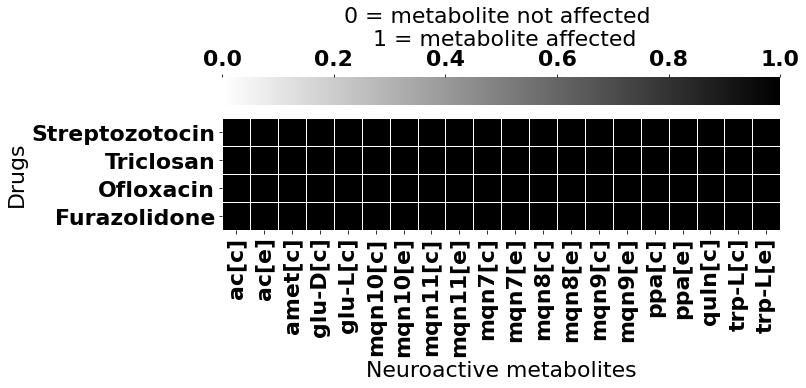

In [26]:
plt.figure(figsize = (10,5))


font = {'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

s=sns.heatmap(sorteddf,vmin=0, vmax=1, cmap=plt.get_cmap('binary'), xticklabels=True, yticklabels=True, cbar_kws={'label': '0 = metabolite not affected \n 1 = metabolite affected', 'location': 'top'}, linewidths=0.5, square=True)

s.set(xlabel='Neuroactive metabolites', ylabel='Drugs')

# plt.savefig('neuroDrugs_affectedNeuroMetabs_curated.png', bbox_inches="tight")